In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
dados = pd.read_csv("heart_rate.csv")

In [3]:
dados.drop(["heart_rate_update_time", "heart_rate_create_time", "heart_rate_end_time"], axis = 1, inplace = True)

In [4]:
dados.columns

Index(['heart_rate_start_time', 'heart_rate_max', 'heart_rate_min',
       'heart_rate'],
      dtype='object')

In [5]:
dados.rename(columns = {"heart_rate_start_time": "inicio", "heart_rate_max": "maximo", "heart_rate_min": "minimo", "heart_rate": "frequencia"}, inplace = True)

In [6]:
dados['aumento_frequencia'] = dados['frequencia'] - dados['frequencia'].shift(-1)
dados['aceleracao_frequencia'] = dados['aumento_frequencia'] - dados['aumento_frequencia'].shift(-1)
dados["intervalo_min_max"] = dados.maximo - dados.minimo
dados['aumento_intervalo'] = dados['intervalo_min_max'] - dados['intervalo_min_max'].shift(-1)
dados['aceleracao_intervalo'] = dados['aumento_intervalo'] - dados['aumento_intervalo'].shift(-1)
dados["frequencia_posterior"] = dados["frequencia"].shift(+1)
dados.inicio = pd.to_datetime(dados.inicio)
dados.set_index("inicio", inplace = True)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [8]:
dados.corr(method = "spearman")

,maximo,minimo,frequencia,aumento_frequencia,aceleracao_frequencia,intervalo_min_max,aumento_intervalo,aceleracao_intervalo,frequencia_posterior
maximo,1.000000,0.422339,0.818729,0.230666,0.100362,0.882829,0.230781,0.120121,0.639839
minimo,0.422339,1.000000,0.749911,0.107322,0.007342,0.011594,-0.120415,-0.107374,0.559307
frequencia,0.818729,0.749911,1.000000,0.264355,0.102741,0.519141,0.081324,0.020815,0.755390
aumento_frequencia,0.230666,0.107322,0.264355,1.000000,0.683788,0.195856,0.424792,0.272113,0.200265
aceleracao_frequencia,0.100362,0.007342,0.102741,0.683788,1.000000,0.088019,0.351857,0.418298,0.058079
intervalo_min_max,0.882829,0.011594,0.519141,0.195856,0.088019,1.000000,0.333898,0.182047,0.432125
aumento_intervalo,0.230781,-0.120415,0.081324,0.424792,0.351857,0.333898,1.000000,0.769620,0.078979
aceleracao_intervalo,0.120121,-0.107374,0.020815,0.272113,0.418298,0.182047,0.769620,1.000000,0.028767
frequencia_posterior,0.639839,0.559307,0.755390,0.200265,0.058079,0.432125,0.078979,0.028767,1.000000


In [9]:
dados_treinamento = dados[["maximo", "minimo", "frequencia", "aumento_frequencia", "frequencia_posterior"]]

In [10]:
lixo = dados_treinamento.loc[dados_treinamento.maximo == 0].index
dados_treinamento.drop(lixo, inplace = True)
lixo = dados_treinamento.loc[dados_treinamento.frequencia_posterior.isna()].index
dados_treinamento.drop(lixo, inplace = True)

In [11]:
x = dados_treinamento[["maximo", "minimo", "frequencia", "aumento_frequencia"]]
y = dados_treinamento["frequencia_posterior"]

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, shuffle = True, random_state = 7)

In [13]:
#model = DecisionTreeRegressor()
#kfold = KFold(n_splits = 5, random_state = 7, shuffle = True)
#parametros = {"criterion": ["mse", "friedman_mse", "mae"], "max_depth": [2, 3, 5, 6, 8], "min_samples_split": [2, 3, 5, 6, 8], "min_samples_leaf": [1, 2, 3, 5, 6, 10], "random_state": [7]}
#grid = GridSearchCV(estimator = model, cv = kfold, param_grid = parametros, scoring = "r2")
#grid_resultado = grid.fit(x_train, y_train)
#resultados = pd.DataFrame(grid_resultado.cv_results_)

In [14]:
#resultados.loc[resultados.rank_test_score == 1]

In [15]:
#grid_resultado.best_params_

In [16]:
from sklearn import metrics
tree = DecisionTreeRegressor(criterion = 'mse',
 max_depth = 5,
 min_samples_leaf = 10,
 min_samples_split = 2,
 random_state = 7)

tree.fit(x_train, y_train)
y_previsto_tree = tree.predict(x_test)
print("A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: {}".format(metrics.r2_score(y_test, y_previsto_tree).round(5)))

A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: 0.45765


In [17]:
predicao = pd.DataFrame(y_test)
predicao["frequencia_prevista"] = y_previsto_tree
predicao.head()

,frequencia_posterior,frequencia_prevista
inicio,,
2021-01-08 00:00:00,82.0,83.968085
2021-01-29 18:00:00,74.0,80.615464
2020-07-08 11:00:00,89.0,89.315909
2020-06-26 01:43:00,77.0,67.769029
2020-12-07 08:00:00,64.0,67.769029


In [18]:
predicao["diferença"] = (predicao["frequencia_posterior"] - predicao["frequencia_prevista"]).abs()

In [19]:
predicao.frequencia_prevista = predicao.frequencia_prevista.round(2)
predicao.diferença = predicao.diferença.round(2)
predicao.head()

,frequencia_posterior,frequencia_prevista,diferença
inicio,,,
2021-01-08 00:00:00,82.0,83.97,1.97
2021-01-29 18:00:00,74.0,80.62,6.62
2020-07-08 11:00:00,89.0,89.32,0.32
2020-06-26 01:43:00,77.0,67.77,9.23
2020-12-07 08:00:00,64.0,67.77,3.77


In [20]:
predicao.rename(columns = {"frequencia_posterior": "frequencia_real"}, inplace = True)

In [21]:
final = pd.merge(dados, predicao, left_index=True, right_index=True, how = "left")

In [22]:
final["frequencia_anterior"] = final["frequencia"].shift(-1)

In [23]:
predicao = final[["frequencia_real", "frequencia_prevista", "diferença", "frequencia_anterior"]]

In [24]:
lixo = predicao.loc[predicao.frequencia_prevista.isna()].index
predicao.drop(lixo, inplace = True)

In [25]:
predicao["diferença_prevista_anterior"] = (predicao["frequencia_prevista"] - predicao["frequencia_anterior"]).abs()

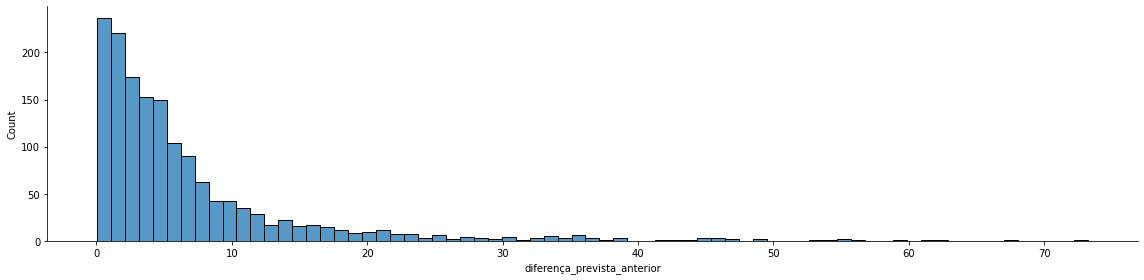

In [26]:
sns.displot(data = predicao.diferença_prevista_anterior, height = 4, aspect = 4)

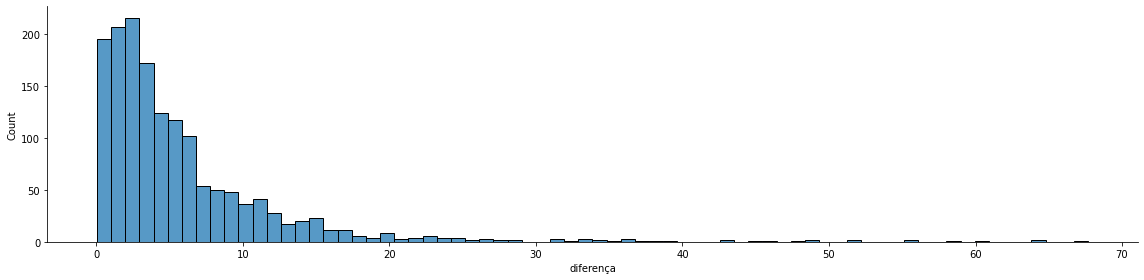

In [27]:
sns.displot(data = predicao.diferença, height = 4, aspect = 4)

<AxesSubplot:xlabel='frequencia_anterior', ylabel='frequencia_prevista'>

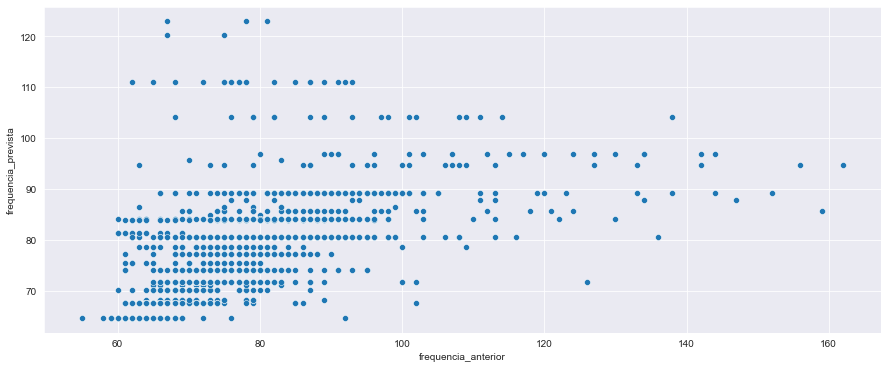

In [28]:
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.scatterplot(x = predicao["frequencia_anterior"],y = predicao["frequencia_prevista"])

In [29]:
#model = KNeighborsRegressor()
#kfold = KFold(n_splits = 5, random_state = 7)
#parametros = {"n_neighbors": [2, 3, 5, 6, 8, 10], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree", "brute"], "p": [1, 2]}
#grid = GridSearchCV(estimator = model, cv = kfold, param_grid = parametros, scoring = "r2")
#grid_resultado = grid.fit(x_train, y_train)
#resultados = pd.DataFrame(grid_resultado.cv_results_)
#resultados.loc[resultados.rank_test_score == 1]

In [30]:
#grid_resultado.best_params_

In [31]:
knn = KNeighborsRegressor(algorithm = "brute", n_neighbors = 10, p = 2, weights = "uniform")
knn.fit(x_train, y_train)
y_previsto_knn = knn.predict(x_test)
print("A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: {}".format(metrics.r2_score(y_test, y_previsto_knn).round(5)))

A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: 0.44416


In [32]:
predicao_knn = pd.DataFrame(y_test)
predicao_knn["frequencia_prevista"] = y_previsto_tree

In [33]:
predicao_knn["diferença"] = (predicao_knn["frequencia_posterior"] - predicao_knn["frequencia_prevista"]).abs()

In [34]:
predicao_knn.frequencia_prevista = predicao_knn.frequencia_prevista.round(2)
predicao_knn.diferença = predicao_knn.diferença.round(2)

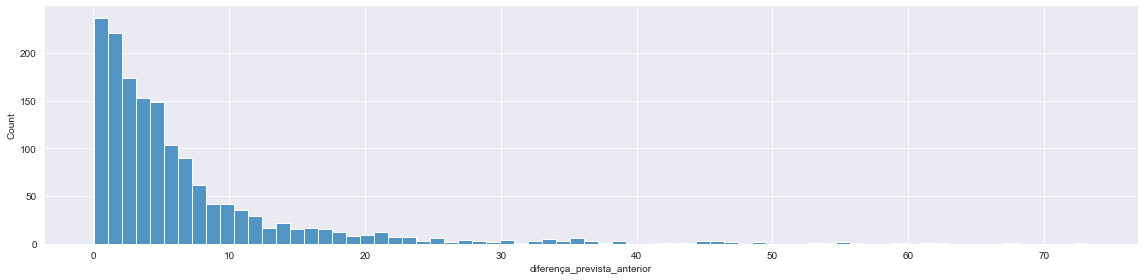

In [35]:
predicao_knn.rename(columns = {"frequencia_posterior": "frequencia_real"}, inplace = True)
final_knn = pd.merge(dados, predicao_knn, left_index=True, right_index=True, how = "left")
final_knn["frequencia_anterior"] = final_knn["frequencia"].shift(-1)
predicao_knn = final_knn[["frequencia_real", "frequencia_prevista", "diferença", "frequencia_anterior"]]
lixo = predicao_knn.loc[predicao_knn.frequencia_prevista.isna()].index
predicao_knn.drop(lixo, inplace = True)
predicao_knn["diferença_prevista_anterior"] = (predicao_knn["frequencia_prevista"] - predicao_knn["frequencia_anterior"]).abs()
sns.displot(data = predicao_knn.diferença_prevista_anterior, height = 4, aspect = 4)

<AxesSubplot:xlabel='frequencia_anterior', ylabel='frequencia_prevista'>

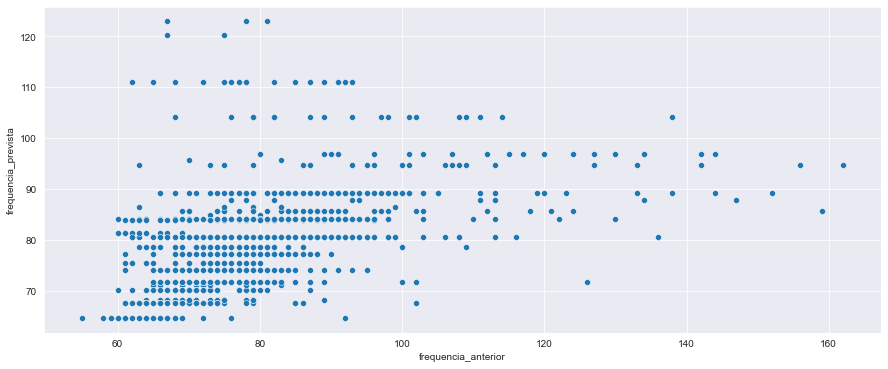

In [36]:
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.scatterplot(x = predicao_knn["frequencia_anterior"],y = predicao_knn["frequencia_prevista"])

In [37]:
#model = RandomForestRegressor()
#kfold = KFold(n_splits = 5, random_state = 7)
#parametros = {"n_estimators": [100], "criterion": ["mse", "mae"], "min_samples_split": [2, 3, 5], "min_samples_leaf": [1, 2, 3, 4, 5], "random_state": [7]}
#grid = GridSearchCV(estimator = model, cv = kfold, param_grid = parametros, scoring = "r2")
#grid_resultado = grid.fit(x_train, y_train)
#resultados = pd.DataFrame(grid_resultado.cv_results_)
#resultados.loc[resultados.rank_test_score == 1]

In [38]:
#grid_resultado.best_params_

In [39]:
forest = RandomForestRegressor(criterion = 'mse', min_samples_leaf = 3, min_samples_split = 2, n_estimators = 100, random_state = 7)

In [40]:
forest.fit(x_train, y_train)
y_previsto_forest = forest.predict(x_test)
print("A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: {}".format(metrics.r2_score(y_test, y_previsto_forest).round(5)))

A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: 0.44439


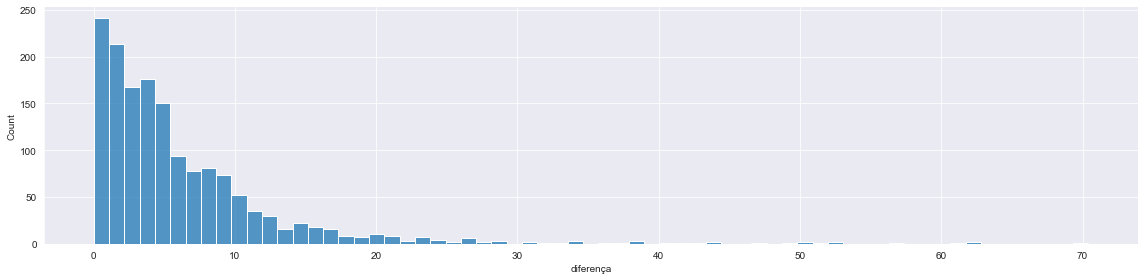

In [41]:
predicao_forest = pd.DataFrame(y_test)
predicao_forest["frequencia_prevista"] = y_previsto_forest
predicao_forest["diferença"] = (predicao_forest["frequencia_posterior"] - predicao_forest["frequencia_prevista"]).abs()
predicao_forest.frequencia_prevista = predicao_forest.frequencia_prevista.round(2)
predicao_forest.diferença = predicao_forest.diferença.round(2)
predicao_forest.rename(columns = {"frequencia_posterior": "frequencia_real"}, inplace = True)
final_forest = pd.merge(dados, predicao_forest, left_index=True, right_index=True, how = "left")
final_forest["frequencia_anterior"] = final_forest["frequencia"].shift(-1)
predicao_forest = final_forest[["frequencia_real", "frequencia_prevista", "diferença", "frequencia_anterior"]]
lixo = predicao_forest.loc[predicao_forest.frequencia_prevista.isna()].index
predicao_forest.drop(lixo, inplace = True)
predicao_forest["diferença_prevista_anterior"] = (predicao_forest["frequencia_prevista"] - predicao_forest["frequencia_anterior"]).abs()
sns.displot(data = predicao_forest.diferença, height = 4, aspect = 4)

In [42]:
predicao_forest

,frequencia_real,frequencia_prevista,diferença,frequencia_anterior,diferença_prevista_anterior
inicio,,,,,
2021-03-10 17:00:00,80.0,78.32,1.68,91.0,12.68
2021-03-10 13:00:00,72.0,71.50,0.50,82.0,10.50
2021-03-10 09:00:00,74.0,62.93,11.07,61.0,1.93
2021-03-10 04:00:00,59.0,63.80,4.80,69.0,5.20
2021-03-09 22:00:00,79.0,78.06,0.94,76.0,2.06
...,...,...,...,...,...
2020-05-04 00:51:43,126.0,73.82,52.18,69.0,4.82
2020-05-01 00:01:56,69.0,86.36,17.36,83.0,3.36
2020-03-12 22:00:00,92.0,81.31,10.69,69.0,12.31


<AxesSubplot:xlabel='frequencia_real', ylabel='frequencia_prevista'>

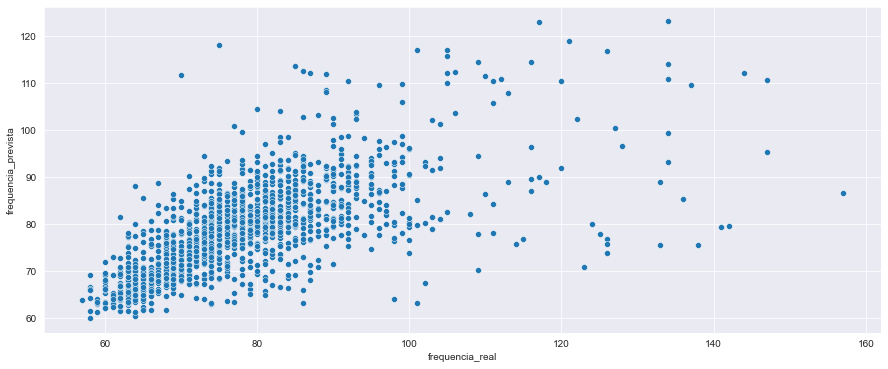

In [43]:
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.scatterplot(x = predicao_forest["frequencia_real"],y = predicao_forest["frequencia_prevista"])

In [44]:
model = GradientBoostingRegressor()
kfold = KFold(n_splits = 5, random_state = 7)
parametros = {"n_estimators": [100, 200], "criterion": ["friedman_mse", "mse"], "min_samples_split": [2, 3, 5], "min_samples_leaf": [1, 2, 3, 4, 5], "random_state": [7]}
grid = GridSearchCV(estimator = model, cv = kfold, param_grid = parametros, scoring = "r2")
grid_resultado = grid.fit(x_train, y_train)
resultados = pd.DataFrame(grid_resultado.cv_results_)
resultados.loc[resultados.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.185550,0.002959,0.003201,0.0004,friedman_mse,1,3,100,7,"{'criterion': 'friedman_mse', 'min_samples_lea...",0.47533,0.442492,0.48365,0.507264,0.461824,0.474112,0.021644,1
32,0.231016,0.029238,0.003201,0.0004,mse,1,3,100,7,"{'criterion': 'mse', 'min_samples_leaf': 1, 'm...",0.47533,0.442492,0.48365,0.507264,0.461824,0.474112,0.021644,1


In [45]:
grid_resultado.best_params_

{'criterion': 'friedman_mse',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100,
 'random_state': 7}

In [46]:
boost = GradientBoostingRegressor(criterion = "friedman_mse", min_samples_leaf = 1, min_samples_split = 3, n_estimators = 100, random_state = 7)

In [47]:
boost.fit(x_train, y_train)
y_previsto_boost = boost.predict(x_test)
print("A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: {}".format(metrics.r2_score(y_test, y_previsto_boost).round(5)))

A acurácia das predições do modelo pode ser descrita por meio de um R² igual a: 0.48145


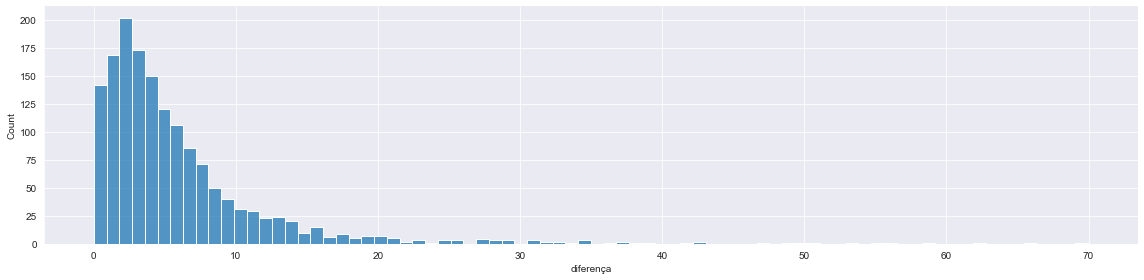

In [48]:
predicao_boost = pd.DataFrame(y_test)
predicao_boost["frequencia_prevista"] = y_previsto_boost
predicao_boost["diferença"] = (predicao_boost["frequencia_posterior"] - predicao_boost["frequencia_prevista"]).abs()
predicao_boost.frequencia_prevista = predicao_boost.frequencia_prevista.round(2)
predicao_boost.diferença = predicao_boost.diferença.round(2)
predicao_boost.rename(columns = {"frequencia_posterior": "frequencia_real"}, inplace = True)
final_boost = pd.merge(dados, predicao_boost, left_index=True, right_index=True, how = "left")
final_boost["frequencia_anterior"] = final_boost["frequencia"].shift(-1)
predicao_boost = final_boost[["frequencia_real", "frequencia_prevista", "diferença", "frequencia_anterior"]]
lixo = predicao_boost.loc[predicao_boost.frequencia_prevista.isna()].index
predicao_boost.drop(lixo, inplace = True)
predicao_boost["diferença_prevista_anterior"] = (predicao_boost["frequencia_prevista"] - predicao_boost["frequencia_anterior"]).abs()
sns.displot(data = predicao_boost.diferença, height = 4, aspect = 4)

[Text(0, 60.0, '40.0'),
 Text(0, 70.0, '60.0'),
 Text(0, 80.0, '80.0'),
 Text(0, 90.0, '100.0'),
 Text(0, 100.0, '120.0'),
 Text(0, 110.0, '140.0'),
 Text(0, 120.0, '160.0'),
 Text(0, 130.0, '180.0')]

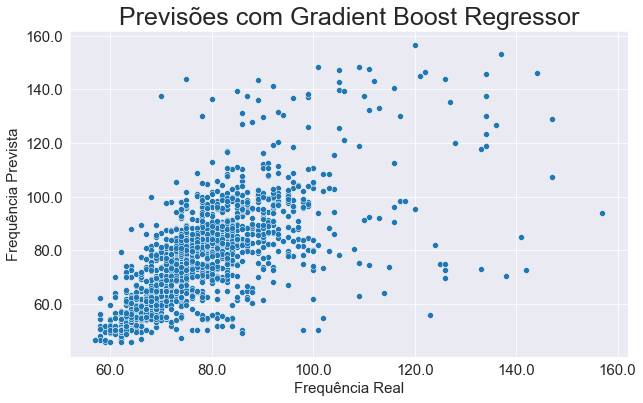

In [49]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
ax = sns.scatterplot(x = predicao_boost["frequencia_real"],y = predicao_boost["frequencia_prevista"])
ax.set_xlabel("Frequência Real", fontsize = 15)
ax.set_ylabel("Frequência Prevista", fontsize = 15)
ax.set_title("Previsões com Gradient Boost Regressor", fontsize = 25)
ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)
ax.set_yticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)

[Text(0, 60.0, '40.0'),
 Text(0, 70.0, '60.0'),
 Text(0, 80.0, '80.0'),
 Text(0, 90.0, '100.0'),
 Text(0, 100.0, '120.0'),
 Text(0, 110.0, '140.0'),
 Text(0, 120.0, '160.0'),
 Text(0, 130.0, '180.0')]

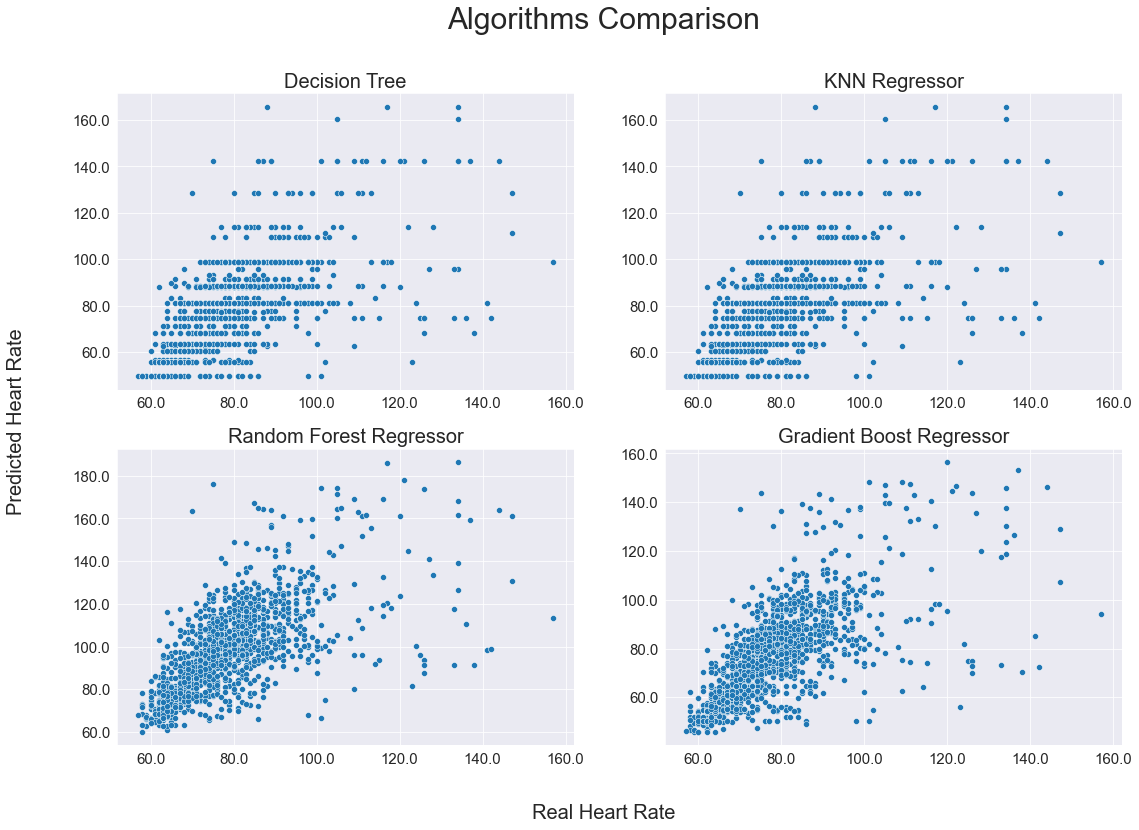

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Algorithms Comparison', fontsize = 30)
fig.text(0.5, 0.04, 'Real Heart Rate', ha='center', fontsize = 20)
fig.text(0.04, 0.5, 'Predicted Heart Rate', va='center', rotation='vertical', fontsize = 20)
sns.set_style("darkgrid")
fig.show


ax = sns.scatterplot(x = predicao["frequencia_real"],y = predicao["frequencia_prevista"], ax = axes[0, 0], palette = sns.color_palette("tab10", 40))
ax.set_title("Decision Tree", fontsize = 20)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)
ax.set_yticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)



bx = sns.scatterplot(x = predicao_knn["frequencia_real"],y = predicao_knn["frequencia_prevista"], ax = axes[0, 1])
bx.set_title("KNN Regressor", fontsize = 20)
bx.xaxis.label.set_visible(False)
bx.yaxis.label.set_visible(False)
bx.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)
bx.set_yticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)


cx = sns.scatterplot(x = predicao_forest["frequencia_real"],y = predicao_forest["frequencia_prevista"], ax = axes[1, 0])
cx.set_title("Random Forest Regressor", fontsize = 20)
cx.xaxis.label.set_visible(False)
cx.yaxis.label.set_visible(False)
cx.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)
cx.set_yticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)


dx = sns.scatterplot(x = predicao_boost["frequencia_real"],y = predicao_boost["frequencia_prevista"], ax = axes[1, 1])
dx.set_title("Gradient Boost Regressor", fontsize = 20)
dx.xaxis.label.set_visible(False)
dx.yaxis.label.set_visible(False)
dx.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)
dx.set_yticklabels([str(i) for i in ax.get_xticks()], fontsize = 15)

In [51]:
len(dados)

6304

In [52]:
dados.describe()

,maximo,minimo,frequencia,aumento_frequencia,aceleracao_frequencia,intervalo_min_max,aumento_intervalo,aceleracao_intervalo,frequencia_posterior
count,6304.00000,6304.000000,6304.000000,6303.000000,6302.000000,6304.000000,6303.000000,6302.000000,6303.000000
mean,92.91085,67.555044,78.520463,-0.000793,0.000000,25.355806,0.003014,-0.000317,78.519435
std,24.33163,12.584481,13.396179,11.322198,17.439009,19.806965,17.217747,27.743411,13.396993
min,0.00000,0.000000,55.000000,-76.000000,-136.000000,0.000000,-112.000000,-224.000000,55.000000
25%,77.00000,61.000000,69.000000,-4.000000,-5.000000,14.000000,-6.000000,-9.000000,69.000000
50%,91.00000,67.000000,77.000000,-1.000000,1.000000,23.000000,0.000000,0.000000,77.000000
75%,104.00000,73.000000,85.000000,3.000000,7.000000,35.000000,5.000000,12.000000,85.000000
max,200.00000,151.000000,164.000000,77.000000,91.000000,131.000000,112.000000,159.000000,164.000000


In [54]:
import pickle

In [56]:
pickle.dump(boost, open("modelo.sav", "wb"))

In [57]:
import requests